# With sWeights: `common_B0toDstDs_Dst_constrHEP_sWeights`
# Fit the complete data (With sWeights and without sWeights)
- Fit to $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit to $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
        - **FINAL CHOICE: $\alpha_L$, $\alpha_R$, $n_L$ free, $n_R$ fixed**
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Combinatorial background (exponential)

- Computation of $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$ and comparison with the ratio of PDG branching ratio
- Computation of $\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}$ and comparison with the ratio of PDG branching ratio. Computation of the rate of misidentified $K$ as $\pi$

Those two fits are not simultaneous. The sWeights are computed in `compute_sWeights_commonHEP.ipynb` with the `hepstats` library

In [22]:
name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"
name_BDT = 'gradient_bkgHighB0M'

name_dataHEP = 'common_Dst_constrHEP'
name_data_B0toDstDsHEP = 'common_B0toDstDs_Dst_constrHEP'
name_data_Dstto3piHEP = 'common_Dstto3piHEP'

## Import

In [23]:
import zfit
import timeit
import pandas as pd


from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, load_saved_root, add_constr_Dst, json_to_latex_table, retrieve_params, save_dataframe
from plot.fit import plot_hist_fit_particle
import plot.histogram as h
from fit import launch_fit, define_zparams, save_params, sum_crystalball
from variables import name_params, name_params_B0toDstDs
from plot.tool import fix_plot, save_file

## Load

In [24]:
# df = load_data(years, magnets, type_data='common', vars=['B0_M','tau_M', 'Dst_M'],
#                             cut_DeltaM=True)
df = load_saved_root('common_'+name_BDT, name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient_bkgHighB0M.root


Constrained data

In [4]:
df = add_constr_Dst(df)
var = 'Dst_constr_B0_M'

## Fit to the full `B0_M`

In [5]:
low = 5150.
high = 5545.

In [6]:
df = df.query(f"{var} > {low} and {var} < {high}")

### Data

In [7]:
data_KPiPi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV   
data_B0Ds_params = retrieve_params(name_data_B0toDstDsHEP, name_folder=name_data_B0toDstDsHEP)   
MC_param_results = retrieve_params(name_data_MC, name_folder='MC')
data_params = retrieve_params(name_dataHEP, name_folder=name_dataHEP)

### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_common_Dst_constrHEP


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($B^0|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

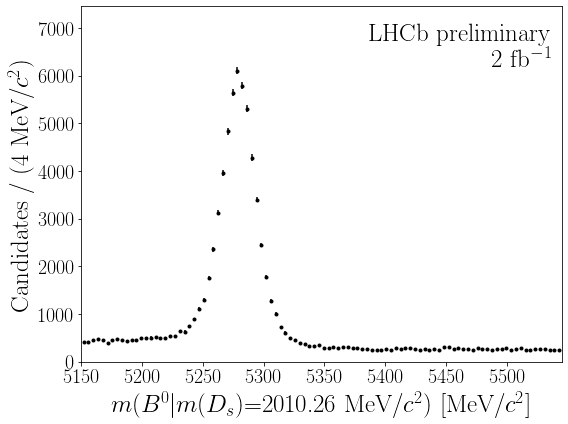

In [8]:
h.plot_hist_particle({name_dataHEP:df}, var,
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black', pos_text_LHC='right')

### Initial values

In [9]:
n_sig_k = 54000
n_bkg_k = 27000
r_bkgK_k = 0.03

variables_data = ['mu', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'frac', 'n_sig', 'lambda', 'n_bkg', 'r_bkgK']

initial_values = {}

for variable in variables_data:
    initial_values[variable] = {'value': data_params[variable], 'floating': True}
initial_values['nR'] = {'value': MC_param_results['nR_MC']     , 'floating': False}

for variable in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{variable}_K'] = {'value': data_KPiPi_params[variable], 'low': None, 'high': None, 'floating': False}

for variable in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{variable}_DsB0'] = {'value': data_B0Ds_params[f'{variable}_B0Ds'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [10]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

### PDFs

In [11]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_DsB0'],zparams['sigma_DsB0'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_DsB0'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df[var], obs=obs)

### Plot

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:520: UserWarning: The function <function Space.limits at 0x7fa2537e3710> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:43: UserWarning: The function <function Space.area at 0x7fa2537e7b00> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


Number of d.o.f. in the model:  11
Reduced chi2:  1.2206274918220403


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/Dst_constr_B0_M_common_Dst_constrHEP_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($B^0|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.22)', ylabel='residuals / $\\sigma$'>)

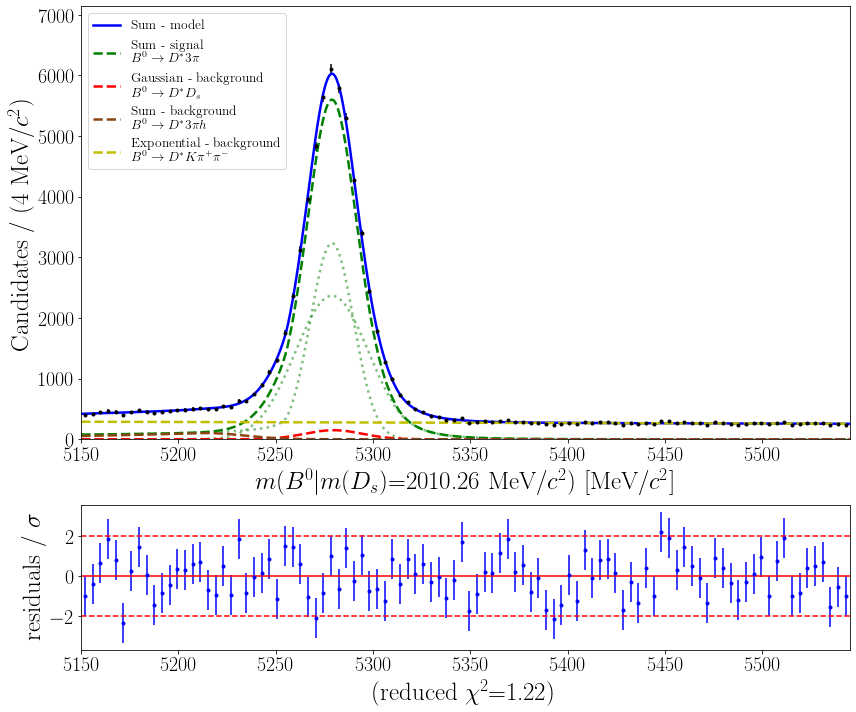

In [12]:
name_data_plot = name_dataHEP + '_details'
plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_dataHEP,
                       colors=['b','g','r','saddlebrown','y'],
                       fontsize_leg=13.5, show_chi2=True,
                       colWidths=[0.06,0.01,0.05,0.06], 
                      )


## Compute sWeights associated with the normalisation mode

In [13]:
from hepstats import splot
import matplotlib.pyplot as plt

In [14]:
weights_hep = splot.compute_sweights(model, data)

In [16]:
weights_sig = weights_hep[zparams['n_sig']]
mass = df[var]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


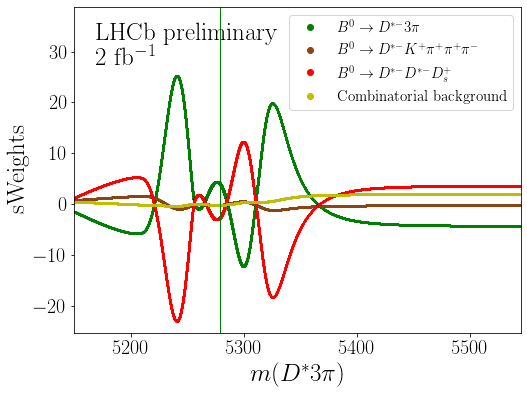

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP/sWeights


In [17]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, weights_hep[zparams['n_sig']],'.', label='$B^0 \\to D^{*-} 3\pi$', markersize=1., color='g')
ax.plot(mass, weights_hep[zparams['n_bkgK']],'.', label='$B^0 \\to D^{*-} K^+ \pi^+ \pi^+ \pi^-$', markersize=1., color='saddlebrown')
ax.plot(mass, weights_hep[zparams['n_sig_DsB0']],'.', label='$B^0 \\to D^{*-} D^{*-} D_s^+$', markersize=1., color='r')
ax.plot(mass, weights_hep[zparams['n_bkg']],'.', label='Combinatorial background', markersize=1., color='y')

ax.set_xlim(low, high) 
fix_plot(ax, ymax=None)

ax.set_xlabel('$m(D^* 3\pi)$',fontsize=25)
ax.set_ylabel('sWeights',fontsize=25)

ymin, ymax = ax.get_ylim()
#ax.set_ylim(ymin, ymax*1.1)
fix_plot(ax, ymax=1.4, pos_text_LHC=[0.05, 0.95, 'left'], ymin_to0=False)
ax.legend(markerscale=12, fontsize=15)

ax.axvline(x=float(zparams['mu']), color='green', linewidth=1.)

plt.show()
plt.close()

save_file(fig, 'sWeights', name_folder=name_dataHEP)

In [20]:
variables = []

df['sWeight'] = weights_sig

In [21]:
save_dataframe(df_fit, name_dataHEP+'_sWeights', 'DecayTree', name_folder='common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_Dst_constrHEP_sWeights.root
